# The Peeking Problem

The purpose of this notebook is to highlight the issue of "peeking" when doing statistical hypothesis tests.

Traditional tests for significance were designed for fixed sample sizes, where the test is carried out only after all the data has been collected. In the modern age, however, automatic data collection and aggregation has made it quite simple to make repeated tests or even allow for continuous monitoring of p-values.

But such an approach greatly inflates the [type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors) rate that the p-value is meant to control.

Various ways to amend this problem have been developed, like [sequential analysis](https://en.wikipedia.org/wiki/Sequential_analysis) and [e-values](https://en.wikipedia.org/wiki/E-values). These are beyond the scope of this notebook.

The code below simulates a number of independent experiments consisting of binomial variables in two groups A and B where the rate of success is equal in both groups. Throughout each experiment, the p-value for a one-sided (B > A) z-test of proportions is continuously computed in order to highlight the peeking problem. The experiment is stopped whenever the threshold $\alpha$ is crossed, and the estimated uplift in group B is calculated.

Each trial is set up using the function **run_trial**, which takes the following parameters:

**final_sample_size:** The full sample size in each group (default 10 000)

**initial_test_sample_size:** The sample size at which the first z-test for proprotions is carried out (default 1 000)

**success_rate**: The success rate of the binomial variables (default 5%)

**alpha:** The p-value threshold at which the difference between B and A is declared significant (default $\alpha = 0.05$).

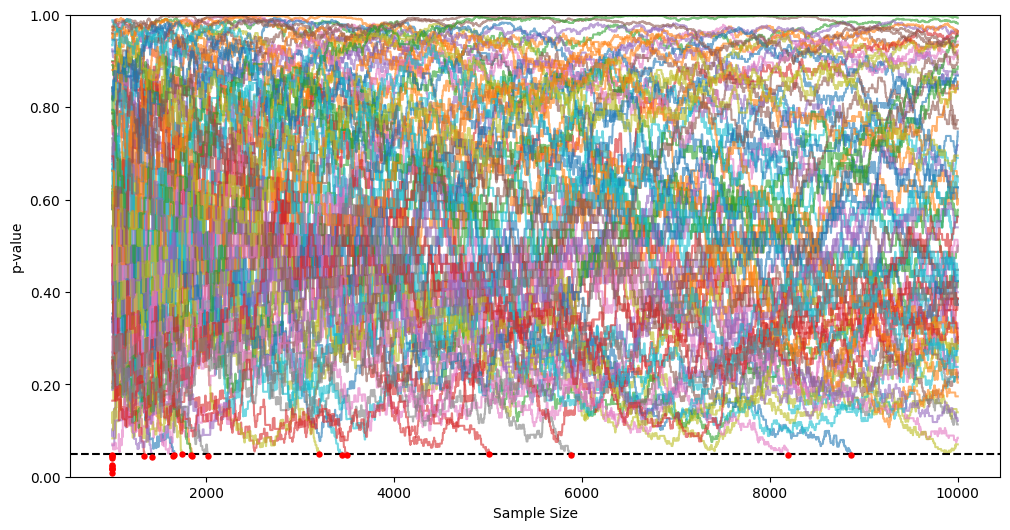

Number of nulls rejected: 25
Average 'uplift': 32.98%


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(333)

def run_trial(final_sample_size = 10_000,
              initial_test_sample_size = 1000,
              success_rate = 0.05,
              alpha = 0.05):


    # Fetch binomial samples from variation A and B
    A = np.random.binomial(1, success_rate, final_sample_size)
    B = np.random.binomial(1, success_rate, final_sample_size)

    # Calculate cumulative sum of successes
    cumsum_A = np.cumsum(A)
    cumsum_B = np.cumsum(B)

    # Calculate initial p-value at initial_test_sample_size
    successes_A_initial = cumsum_A[initial_test_sample_size - 1]
    successes_B_initial = cumsum_B[initial_test_sample_size - 1]
    p_pooled_initial = (successes_A_initial + successes_B_initial) / (2 * initial_test_sample_size)
    se_initial = np.sqrt(p_pooled_initial * (1 - p_pooled_initial) * (2 / initial_test_sample_size))
    z_initial = (successes_B_initial/initial_test_sample_size - successes_A_initial/initial_test_sample_size) / se_initial
    p_value_initial = 1 - stats.norm.cdf(z_initial)

    # Break and return values if significance is already reached
    if p_value_initial < alpha:
        return pd.DataFrame({
            'sample_size': [initial_test_sample_size],
            'p_value': [p_value_initial],
            'successes_A': [successes_A_initial],
            'successes_B': [successes_B_initial]
        })

    # If significance is not reached, keep calculating p-values cumulatively
    sample_sizes = np.arange(initial_test_sample_size, final_sample_size)
    successes_A = cumsum_A[sample_sizes - 1]
    successes_B = cumsum_B[sample_sizes - 1]
    p_A = successes_A / sample_sizes
    p_B = successes_B / sample_sizes
    p_pooled = (successes_A + successes_B) / (2 * sample_sizes)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (2 / sample_sizes))
    z = (p_B - p_A) / se
    p_values = 1 - stats.norm.cdf(z)

    # Find threshold crosses and return values
    cross_indices = np.where(p_values < alpha)[0]
    if cross_indices.size > 0:
        cross_index = cross_indices[0]
        return pd.DataFrame({
            'sample_size': sample_sizes[:cross_index+1],
            'p_value': p_values[:cross_index+1],
            'successes_A': successes_A[:cross_index+1],
            'successes_B': successes_B[:cross_index+1]
        })
    else:
        return pd.DataFrame({
            'sample_size': sample_sizes,
            'p_value': p_values,
            'successes_A': successes_A,
            'successes_B': successes_B
        })

# Set number of trials and p-value threshold
n_trials = 100
alpha = 0.05

# Run trials
trials = [run_trial(alpha = alpha) for _ in range(n_trials)]

# Count threshold crossings and calculate 'uplift'
threshold_crossed = sum(1 for trial
                        in trials
                        if trial['p_value'].iloc[-1] < alpha)
uplifts = []
for trial in trials:
    if trial['p_value'].iloc[-1] < alpha:
        n = trial['sample_size'].iloc[-1]
        p_A = trial['successes_A'].iloc[-1] / n
        p_B = trial['successes_B'].iloc[-1] / n
        uplift = (p_B - p_A) / p_A if p_A != 0 else 0
        uplifts.append(uplift)
avg_uplift = np.mean(uplifts) if uplifts else 0

# Plot
plt.figure(figsize=(12, 6))
for i, trial in enumerate(trials):
    plt.plot(trial['sample_size'], trial['p_value'], alpha=0.6)
    cross_indices = np.where(trial['p_value'] < alpha)[0]
    if cross_indices.size > 0:
        plt.scatter(trial['sample_size'].iloc[cross_indices[0]],
                    trial['p_value'].iloc[cross_indices[0]],
                    color='red', zorder=5, s = 13)
plt.axhline(alpha, color='black', linestyle='--')
plt.xlabel('Sample Size')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.show()

print(f"Number of nulls rejected: {threshold_crossed}")
print(f"Average 'uplift': {avg_uplift:.2%}")

In this case, for the 100 experiments that were simulated, the null hypothesis was rejected a whole 25 times – even though there was no real difference between the groups and the type I error rate was limited to 5%!